In [118]:
from PINNs import PINN, Geometry, Physics, NetworkTrainer, Visualizer, ProblemDomain
import matplotlib.pyplot as plt

### 1. Define Geometry Domain

In [119]:
circle = Geometry.circle(0.2, 0.2, 0.05)
rectangel = Geometry.rectangle([0,1.1], [0,0.41])
area = rectangel - circle

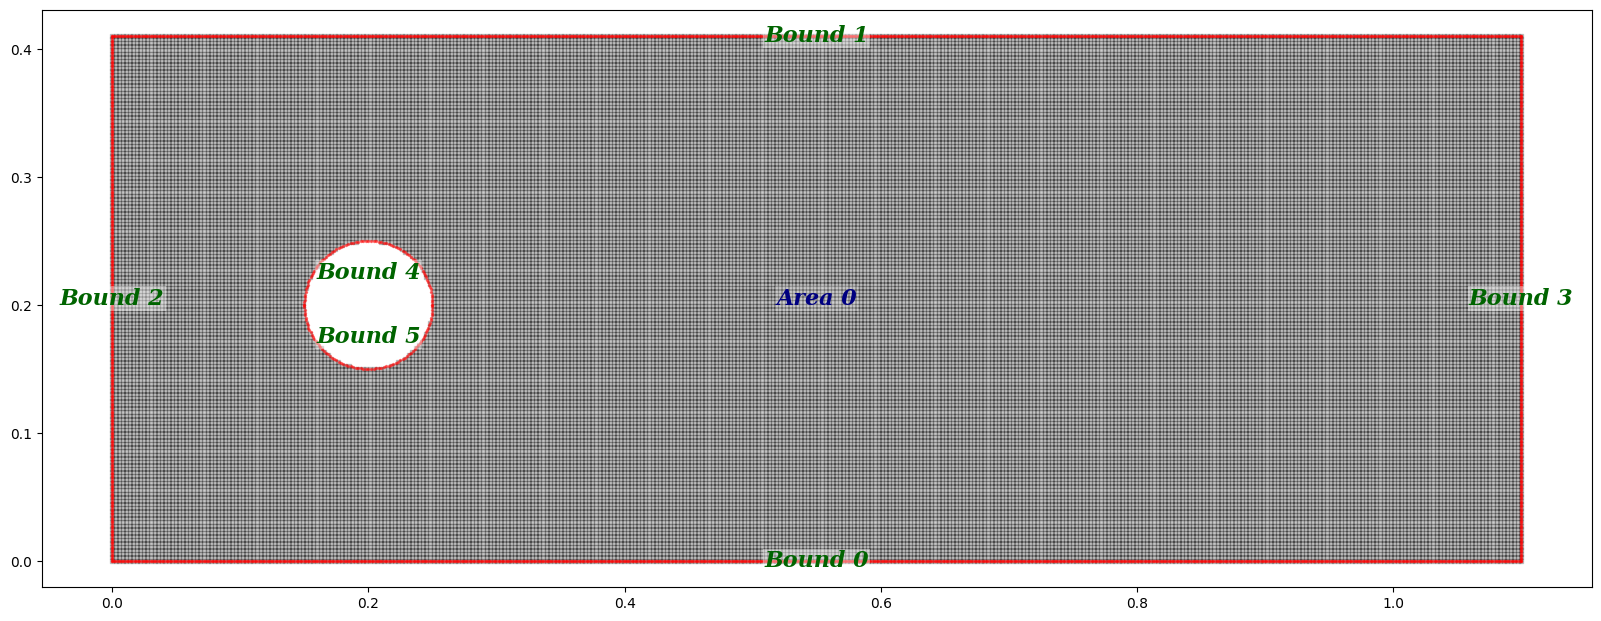

In [120]:
domain = ProblemDomain(rectangel.bound_list + circle.bound_list, [area])
domain.show_setup()

### 2. Define Physics

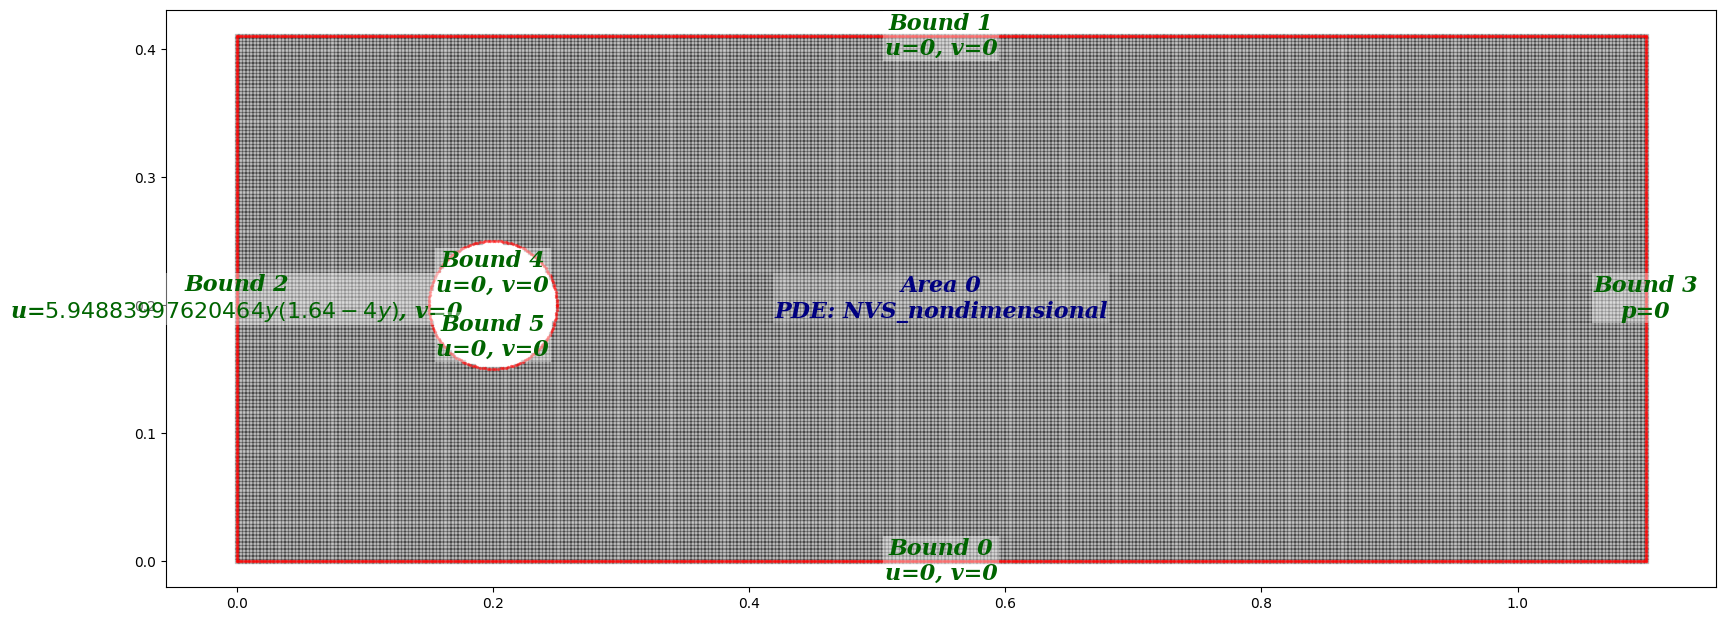

In [121]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[3].define_bc({'p':0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Initial Sampling (mandatory)

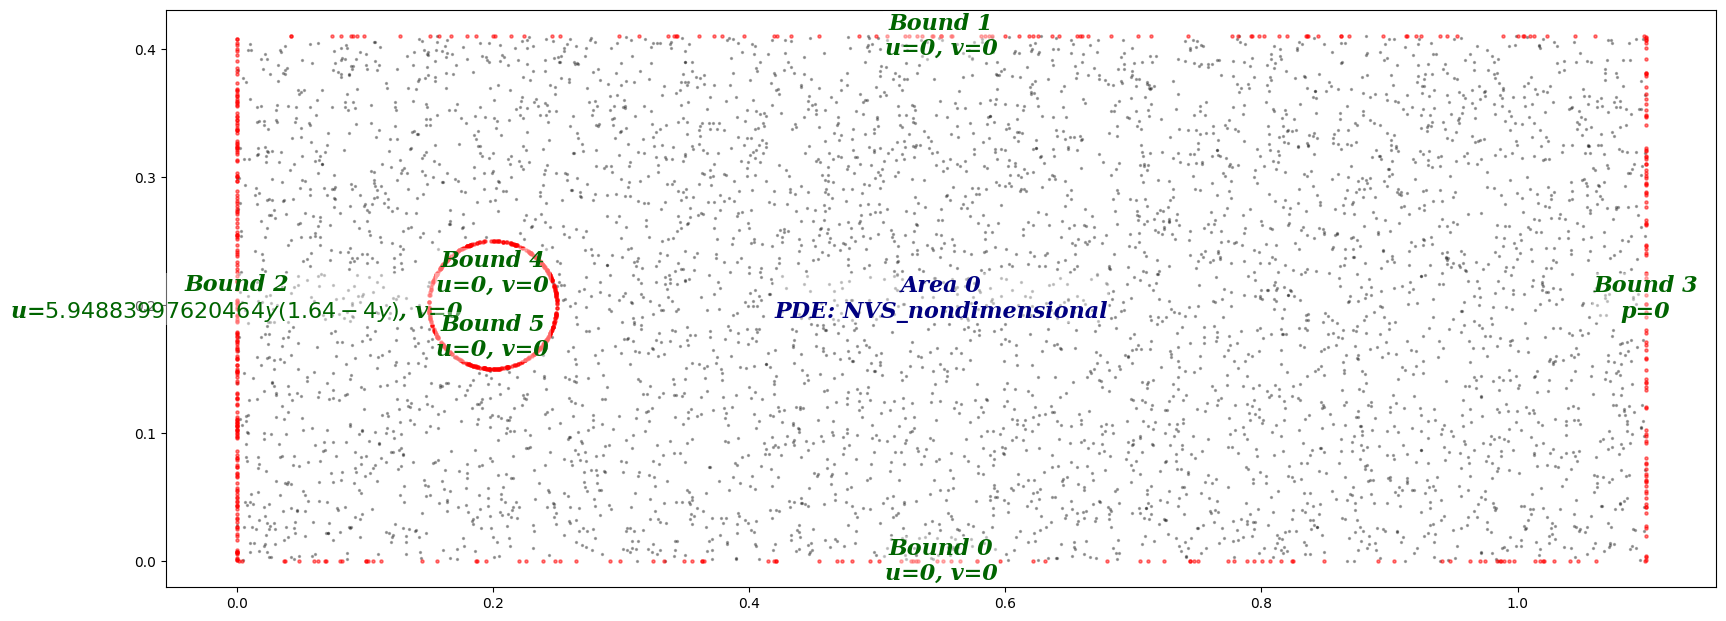

In [122]:
domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')
domain.show_coordinates(display_conditions=True)

## 3. Training PINN

Create model

In [123]:
model0 = PINN(width=40, length=8)

Define Training flow

In [ ]:
# Define the loss calculation function
N = 0
def calc_loss(model):
    global N
    N += 1

    # Add collocation points using RAR scheme
    if N%1000==0:
        domain.sampling_RAR([40, 40, 160, 40, 80, 80], [2000], model, [200, 200, 400, 200, 400, 400], [20000], device='cuda')
    
    # Resampling collocation points using Random-R scheme (less superior to RAR)
    # if N % 100 == 0:
    #     domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        if i == 2: # if inlet bound
            bc_loss += 2*bc.calc_loss(model)
        else:
            bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = 3*bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam optimizer

In [ ]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.0002,
    epochs=6000,
    print_every=250,
    thereshold_loss=0.05,
    device='cuda'
)

epoch 1, total_loss: 3.08127, bc_loss: 1.02708, pde_loss: 0.00003
epoch 251, total_loss: 1.21915, bc_loss: 0.34708, pde_loss: 0.17790
epoch 501, total_loss: 0.82462, bc_loss: 0.20207, pde_loss: 0.21841
epoch 751, total_loss: 0.59900, bc_loss: 0.13770, pde_loss: 0.18590
epoch 1001, total_loss: 1.00608, bc_loss: 0.25200, pde_loss: 0.25008
epoch 1251, total_loss: 0.77694, bc_loss: 0.19556, pde_loss: 0.19027
epoch 1501, total_loss: 0.69645, bc_loss: 0.17604, pde_loss: 0.16833
epoch 1751, total_loss: 0.54251, bc_loss: 0.13193, pde_loss: 0.14671
epoch 2001, total_loss: 0.61513, bc_loss: 0.14109, pde_loss: 0.19186
epoch 2251, total_loss: 0.44145, bc_loss: 0.10824, pde_loss: 0.11672
epoch 2501, total_loss: 0.34845, bc_loss: 0.07938, pde_loss: 0.11030
epoch 2751, total_loss: 0.26126, bc_loss: 0.05225, pde_loss: 0.10452
epoch 3001, total_loss: 0.26982, bc_loss: 0.04484, pde_loss: 0.13530
epoch 3251, total_loss: 0.18575, bc_loss: 0.03500, pde_loss: 0.08074
epoch 3501, total_loss: 0.14246, bc_loss

Then, train the model using LBFGS optimizer

In [126]:
# Train the model
model2 = NetworkTrainer.train_lbfgs(
    model=model1,
    calc_loss=calc_loss,
    epochs=500,
    print_every=50,
    thereshold_loss=0.002,
    device='cuda'
)

epoch 5001, total_loss: 0.06685, bc_loss: 0.00914, pde_loss: 0.03942
epoch 5051, total_loss: 0.02326, bc_loss: 0.00206, pde_loss: 0.01707
epoch 5101, total_loss: 0.01531, bc_loss: 0.00143, pde_loss: 0.01102
epoch 5151, total_loss: 0.00974, bc_loss: 0.00095, pde_loss: 0.00689
epoch 5201, total_loss: 0.00797, bc_loss: 0.00084, pde_loss: 0.00547
epoch 5251, total_loss: 0.00620, bc_loss: 0.00069, pde_loss: 0.00414
epoch 5301, total_loss: 0.00553, bc_loss: 0.00067, pde_loss: 0.00351
epoch 5351, total_loss: 0.00499, bc_loss: 0.00064, pde_loss: 0.00308
epoch 5401, total_loss: 0.00424, bc_loss: 0.00056, pde_loss: 0.00256
epoch 5451, total_loss: 0.00388, bc_loss: 0.00052, pde_loss: 0.00231


Save or Load the model

In [127]:
import pickle

# Save model with pickle
with open("model2.pkl", "wb") as f:
    pickle.dump(model2, f)

# Load model back
with open("model2.pkl", "rb") as f:
    model2 = pickle.load(f)

Display final collocation points

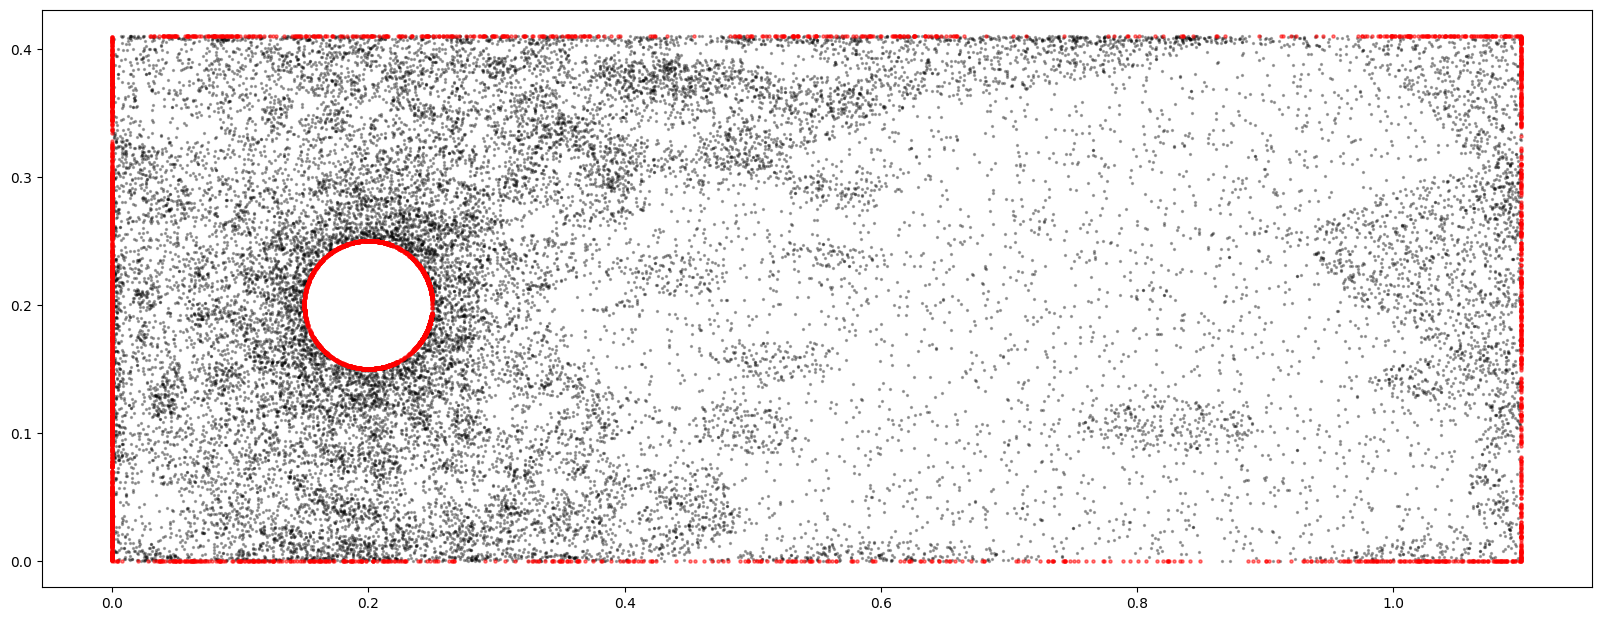

number of bound : 6
        ['0: 500', '1: 500', '2: 1800', '3: 500', '4: 1000', '5: 1000']
        , number of area : 1
        ['0: 24921']


In [ ]:
domain.save_coordinates()
domain.load_coordinates()

domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [129]:
area_visual = Visualizer(model2, domain.area_list[0])
area_visual.sampling_area([500,200])
area_visual.preprocess() # process data

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'total_loss', 'bc_loss', 'pde_loss')


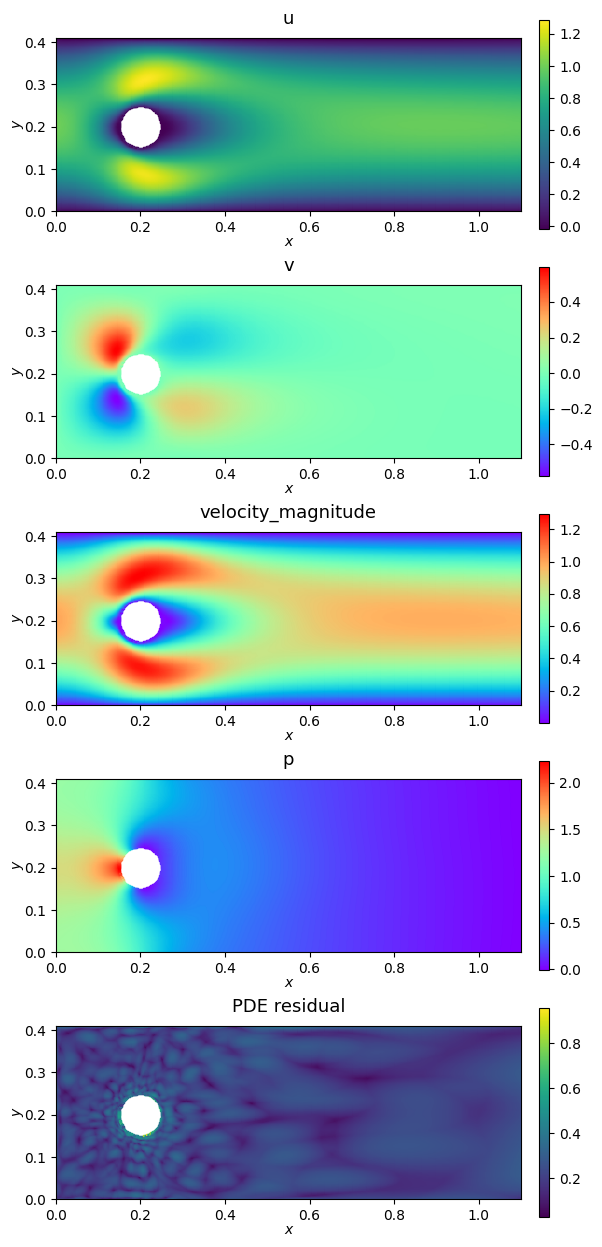

In [130]:
cmap_dict = {
    'u':None,
    'v':'rainbow',
    'velocity_magnitude': 'rainbow',
    'p':'rainbow',
    'PDE residual': None
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_area_2d.savefig('colorplot_area_2d.png')

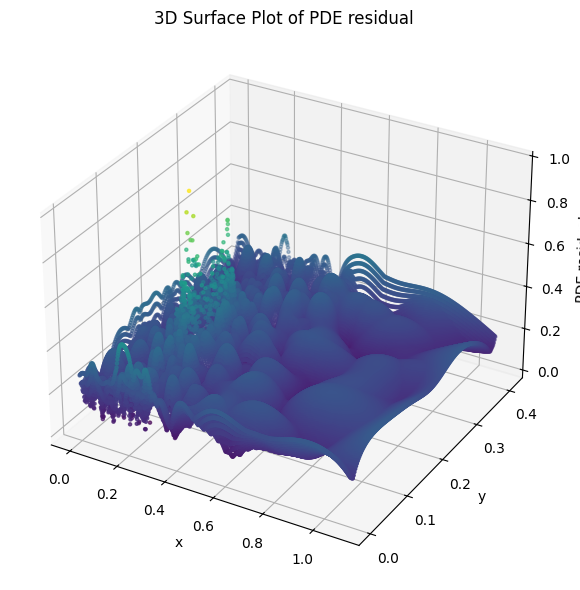

In [131]:
residual_plot_3d = area_visual.plot_data(['PDE residual'])
residual_plot_3d.savefig('residual_plot_3d.png')

### 4.2 Visualize bound

In [132]:
 # Create geometry object by Visualizer
bound_visual = Visualizer(model2, domain.bound_list[3])
bound_visual.sampling_line(100)
bound_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'total_loss', 'bc_loss', 'pde_loss')


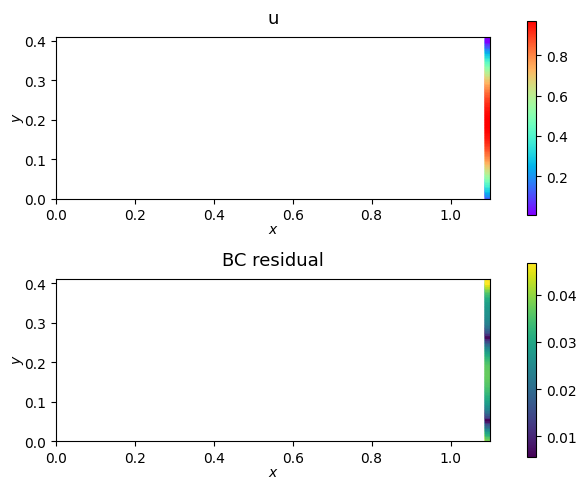

In [133]:
cmap_dict = {'u':'rainbow','BC residual':None}
colorplot_bound = bound_visual.plot_data_on_geometry(cmap_dict, range_x=[0,1.1], range_y=[0,0.41], s=50)
colorplot_bound.savefig('colorplot_bound.png')

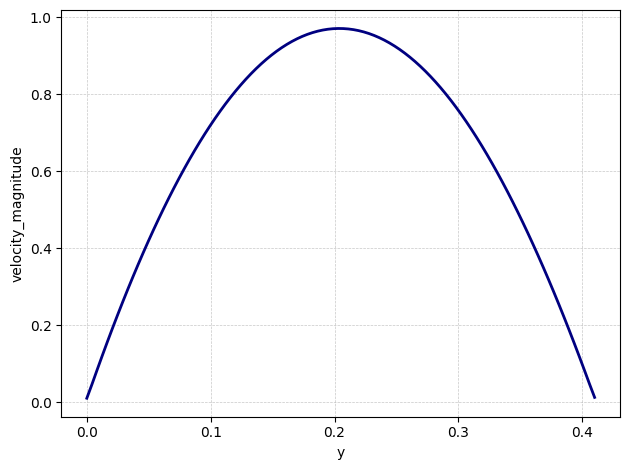

In [134]:
velocity_plot_outlet = bound_visual.plot_data(['velocity_magnitude'])
velocity_plot_outlet.savefig('velocity_plot_outlet.png')

## 4.3 Visualize PINN data

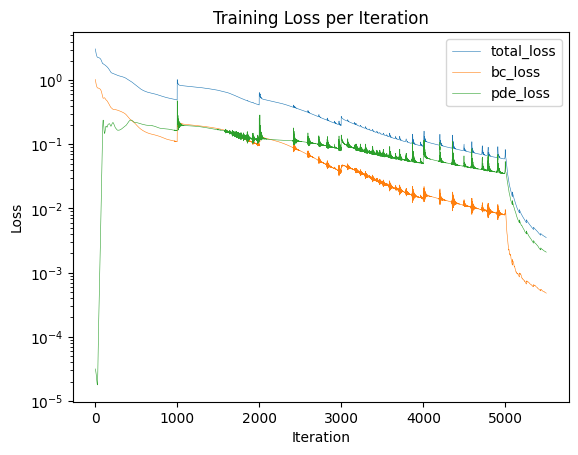

In [135]:
loss_history = bound_visual.plot_loss_evolution(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [140]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual'])


In [148]:
velocity_data = bound_visual.data_dict['u'] #raw pytorch tensor
print(velocity_data.flatten().detach().numpy())

[0.00735123 0.04573748 0.0834031  0.12033598 0.15652585 0.19196874
 0.22665286 0.26057512 0.29373032 0.32611537 0.35772488 0.3885579
 0.41860998 0.44788206 0.47636932 0.50407344 0.5309896  0.5571188
 0.58245826 0.60700846 0.6307651  0.6537291  0.6758975  0.69727135
 0.7178467  0.73762465 0.75660104 0.77477634 0.79214954 0.8087183
 0.8244822  0.8394412  0.8535943  0.86694145 0.8794821  0.8912159
 0.9021435  0.9122666  0.92158544 0.9301008  0.9378141  0.9447279
 0.95084286 0.95615995 0.96068347 0.964412   0.9673495  0.9694979
 0.9708574  0.9714297  0.97121537 0.97021544 0.96843064 0.96585953
 0.9625031  0.95836043 0.95343053 0.9477111  0.94120324 0.9339036
 0.9258112  0.9169251  0.9072429  0.8967638  0.88548744 0.8734134
 0.8605392  0.84686726 0.8323984  0.8171325  0.8010714  0.78421825
 0.76657534 0.74814427 0.7289314  0.7089395  0.6881737  0.66663814
 0.6443399  0.6212825  0.59747314 0.57291555 0.5476195  0.5215879
 0.4948293  0.46734983 0.43915236 0.41024518 0.38063568 0.35032555
 0.3